# **Mounting Drive and managing paths**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
!pip install -q segmentation-models-pytorch #We can choose to also import the UNet model directly


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


# Imports

In [ ]:
import os
import time
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import random
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

plt.style.use("dark_background")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataFrame Construction

* Dataframe consisting of  image paths, mask paths and tumor flag

* Using dataframe to split data into train, val and test

In [ ]:
files_dir = '/content/drive/MyDrive/Kaggle/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob(files_dir + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,1
1,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
2,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
4,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
...,...,...,...
3924,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3925,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3926,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3927,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0


In [ ]:
files_df.to_csv('diagnosis.csv')

In [ ]:
#Saved it just for reference
files_df = pd.read_csv('diagnosis.csv')

In [ ]:
files_df = files_df.drop(['Unnamed: 0'], axis = 1)

In [ ]:
files_df

,image_path,mask_path,diagnosis
0,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,1
1,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
2,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
4,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
...,...,...,...
3924,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3925,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3926,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0
3927,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,/content/drive/MyDrive/Kaggle/lgg-mri-segmenta...,0


In [ ]:
def set_seed(seed = 0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

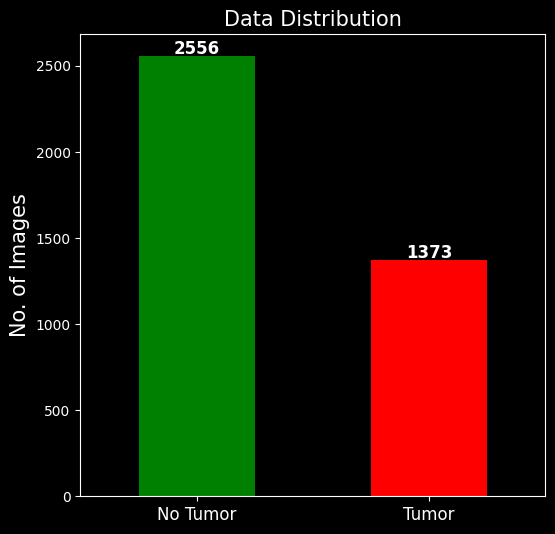

In [ ]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

In [ ]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


# **Custom PyTorch Dataset class**

*   Normalize both image and mask values between 0 and 1
*   Transpose the image to (C, H, W)
*   Match the dimensions of mask and image



In [ ]:
class BrainMRIDataset:
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Data Transformations/Augmentation

In [ ]:
#Image Transforms using Albumentations Library

train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
set_seed()

train_dataset = BrainMRIDataset(train_df, train_transform)
val_dataset = BrainMRIDataset(val_df, val_transform)
test_dataset = BrainMRIDataset(test_df, test_transform)

# **Visualizing the Data**

(-0.5, 1279.5, 255.5, -0.5)

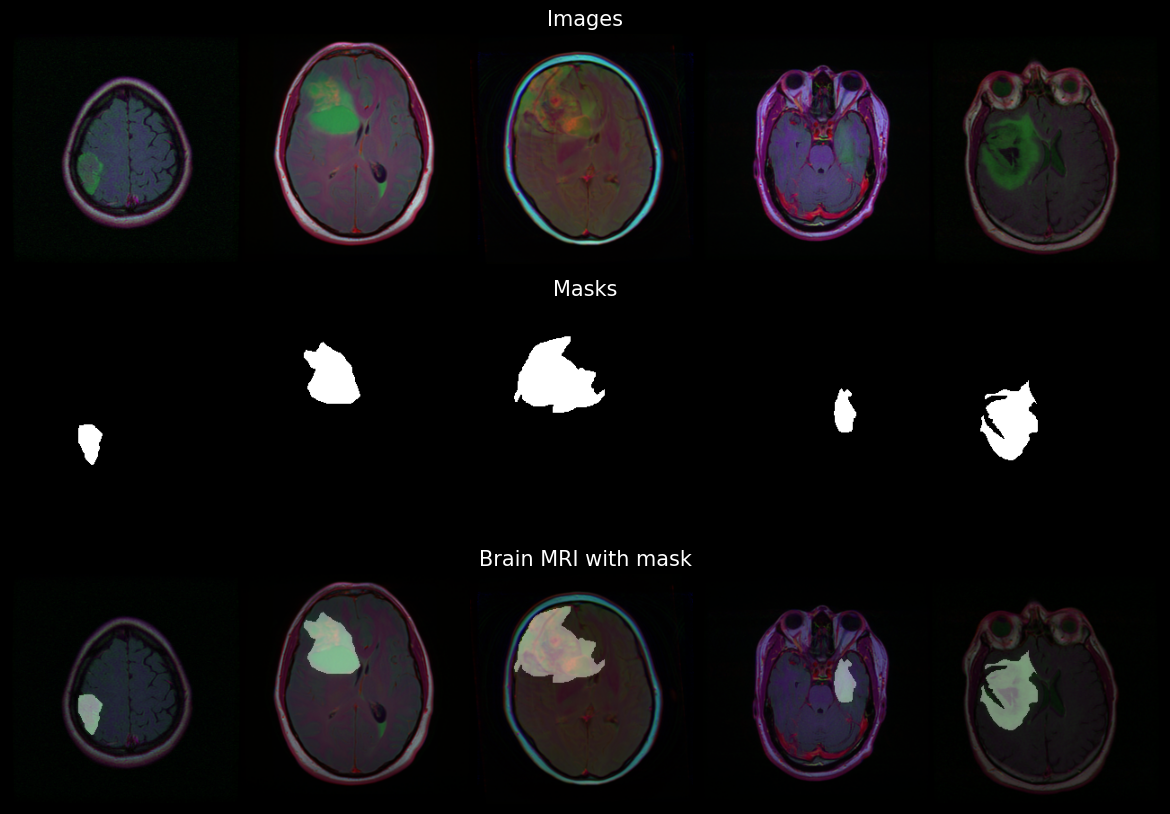

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

set_seed()

images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

In [ ]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [72]:
#Sanity check for dimensions

print('Train dataset:')
dataset_info(train_dataset)
print('Validation dataset:')
dataset_info(val_dataset)
print('Test dataset:')
dataset_info(test_dataset)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



# Creating DataLoader from dataset

In [ ]:
batch_size = 64

set_seed()

#Get Data as minibatches

train_dl = DataLoader(train_dataset,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

set_seed()
val_dl = DataLoader(val_dataset,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

test_dl = DataLoader(test_dataset,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
images, masks = next(iter(train_dl))
print(images.shape) #(batch, channels, h, w)
print(masks.shape) #(batch, channels, h, w) #Mask will have depth of 1

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


## **Visualizing a batch after data augmentations**

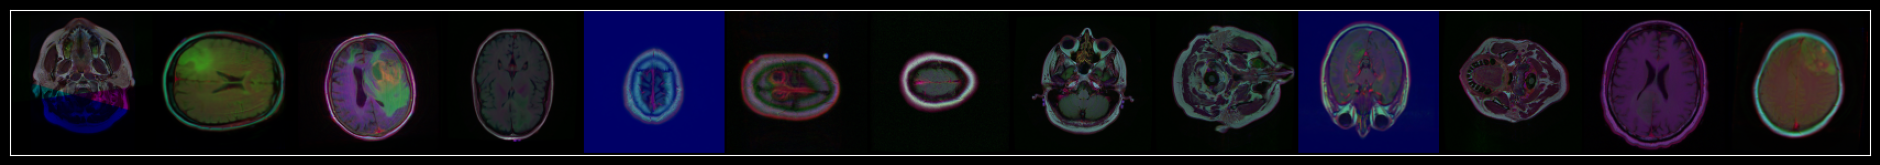

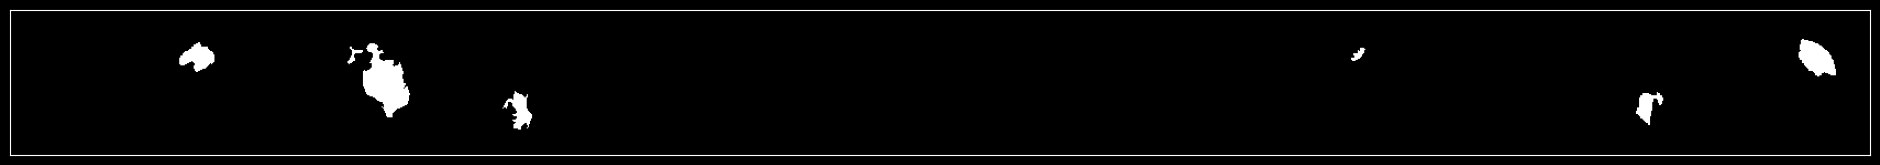

In [ ]:
from torchvision.utils import make_grid

def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))

        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

# **UNet implementation With BatchNorm**


Based on: https://arxiv.org/abs/1505.04597

For reference: https://github.com/milesial/Pytorch-UNet/

In [ ]:
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [73]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear #interpolation for upsampling

        # Encoder (contracting path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        #Bottleneck
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)

        # Decoder (expanding path)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) #Output Layer

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


# **Loss Metrics**

In [ ]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

# Training and Validation Loop

In [ ]:
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())

        #Thresholding the values of segmentation mask into forerground and background
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [ ]:
def eval_loop(model, loader, loss_func, training=True): #Validation
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))


    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 30

In [55]:
# %%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/30 |  Train Loss: 0.984, Val Loss: 1.213, Train DICE: 0.569, Val DICE: 0.059
Epoch: 2/30 |  Train Loss: 0.724, Val Loss: 0.821, Train DICE: 0.631, Val DICE: 0.556
Epoch: 3/30 |  Train Loss: 0.517, Val Loss: 0.548, Train DICE: 0.641, Val DICE: 0.737
Epoch: 4/30 |  Train Loss: 0.403, Val Loss: 0.455, Train DICE: 0.681, Val DICE: 0.789
Epoch: 5/30 |  Train Loss: 0.385, Val Loss: 0.839, Train DICE: 0.677, Val DICE: 0.392
Epoch: 6/30 |  Train Loss: 0.366, Val Loss: 0.421, Train DICE: 0.687, Val DICE: 0.807
Epoch: 7/30 |  Train Loss: 0.324, Val Loss: 0.419, Train DICE: 0.722, Val DICE: 0.796
Epoch: 8/30 |  Train Loss: 0.326, Val Loss: 0.459, Train DICE: 0.717, Val DICE: 0.779
Epoch: 9/30 |  Train Loss: 0.314, Val Loss: 0.363, Train DICE: 0.727, Val DICE: 0.851
Epoch: 10/30 |  Train Loss: 0.297, Val Loss: 0.868, Train DICE: 0.742, Val DICE: 0.411
Epoch: 11/30 |  Train Loss: 0.283, Val Loss: 0.414, Train DICE: 0.753, Val DICE: 0.801
Epoch: 12/30 |  Train Loss: 0.268, Val Loss: 0.362, 

# Accuracy and Loss Curves

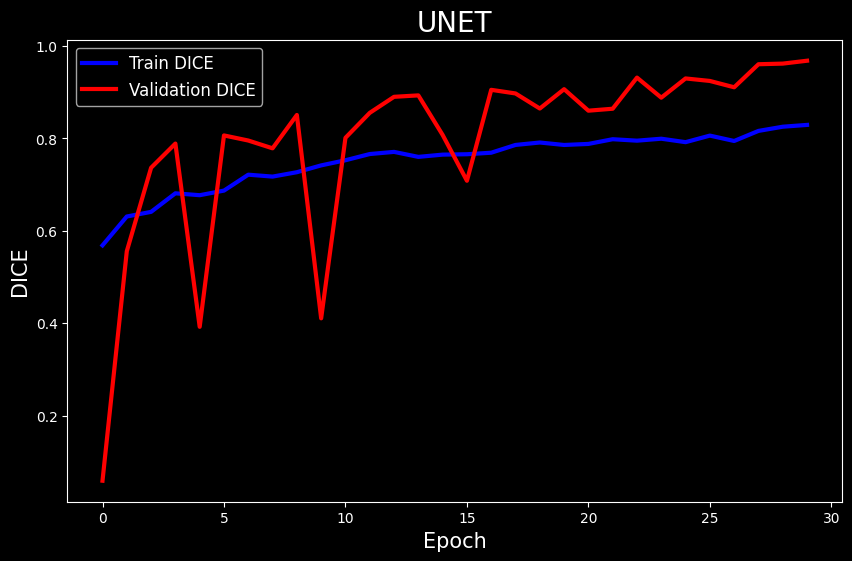

In [56]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

plot_dice_history('UNET', train_dice_history, val_dice_history, num_epochs)

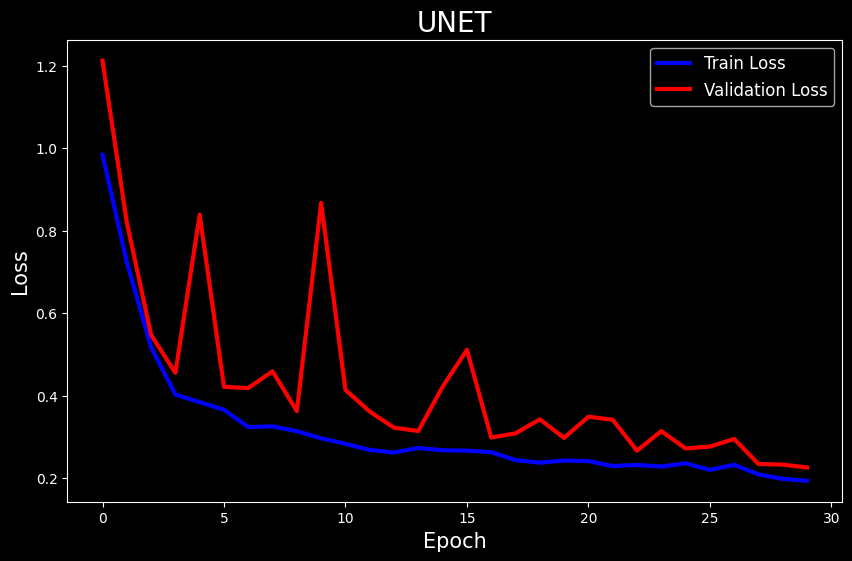

In [66]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, torch.stack(val_loss_history).cpu(), label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

plot_loss_history('UNET', train_loss_history, val_loss_history, num_epochs)

# **Testing IoU on Test Set**

In [67]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean IoU/DICE: 92.144%, Loss: 0.229
CPU times: user 2.98 s, sys: 530 ms, total: 3.51 s
Wall time: 4min 57s


#Visualizing Predicted Mask

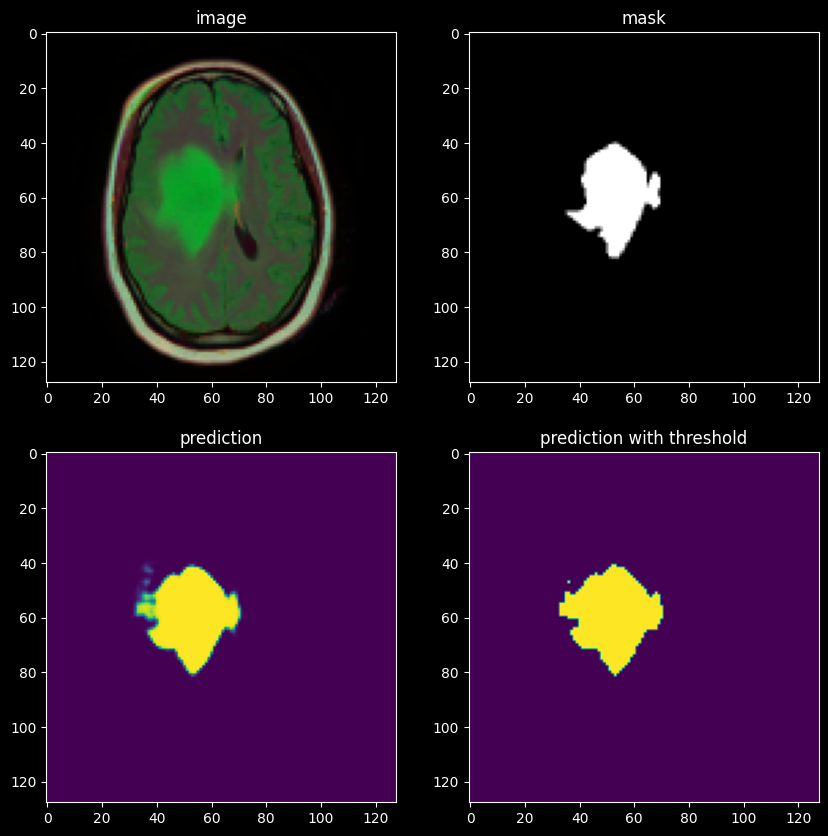

In [71]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()